# Melanoma Health Disparities Analysis
A personal project examining racial disparities in melanoma survival outcomes using SEER cancer registry data.

### Research Question
*Are racial disparities in melanoma survival explained by a later stage at diagnosis and socioeconomic factors, or do disparities persist even after controlling for these factors?*

### Notebook Overview
Survival analysis examining whether racial disparities persist after controlling for clinical and socioeconomic factors.

 **Input:** `melanoma_data_final.csv` from `02_exploratory_analysis.ipynb`
 <br>**Output:** Kaplan-Meier curves, statistics and COX regression results

#### Survival Analysis
**Step 1:** Prepare the melanoma dataset for survival analysis
<br>**Step 2:** Kaplan-Meier survival curves by race
<br>**Step 3:** Stratify K-M survival curves by cancer stage at diagnosis
<br>**Step 4:** Cox proportional hazards regression
- <u><i>Model 1</u>:</i>  Baseline (demographics)
- <u><i>Model 2</u>:</i>  Clinical Factors (stage, acral melanoma)
- <u><i>Model 3</u>:</i>  Socioeconomic Access (income, rural-urban)

### Dataset

**Source:** SEER Research Data, 17 Registries, Nov 2024 Sub (2000-2022)  
**Final sample:** 226,587 cutaneous melanoma cases across 13 variables

The data has been processed to include only:
- Microscopy-confirmed malignant cutaneous melanoma
- Known stage at diagnosis
- First primary tumors only
- Known survival time
- Known race

**Note:** Individual patient-level data cannot be shared publicly per SEER Research Data Agreement. 
<br>Instructions for requesting access and recreating this dataset can be found in the [data README](../data/README.md).

### Analysis Workflow

This is the last notebook in a three-part series:

1. **01_data_cleaning.ipynb** - Data cleaning and filtering
2. **02_exploratory_analysis.ipynb** - Exploratory data analysis and visualization
3. **03_survival_analysis.ipynb** *(this notebook)* - Kaplan-Meier curves and Cox regression models

### GitHub Repository

**GitHub:** https://github.com/kpannoni/melanoma-project

---

## Step 1: Prepare the melanoma dataset for survival analysis
We need to prepare the data for survival analysis by creating an event variable and recoding survival time. 
<br>We'll also create a summary table to describe the final analysis cohort.
### Import final dataset

In [56]:
# Import necessary packages
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load the final data ready for analysis
mel_data = pd.read_csv('../data/melanoma_data_final.csv', header=0, low_memory=False)

# Set the order of racial groups to match previous analysis (ascending by median survival time)
order = ['Black', 'Asian or Pacific Islander', 'Hispanic', 
         'American Indian/Alaska Native', 'White']

# Quick verification of the dataset
print(f"Dataset loaded: {len(mel_data):,} cases")
print(f"Variables: {mel_data.shape[1]}")
print(f"\nColumn names:")
print(mel_data.columns.tolist())


Dataset loaded: 226,587 cases
Variables: 19

Column names:
['age_group', 'sex', 'race', 'year_diag', 'survival_months', 'stage', 'cause_death', 'vital_status', 'histology', 'primary_site', 'marital_status', 'median_income', 'rural_urban', 'race_labels', 'stage_category', 'income_tier', 'metro', 'age_category', 'acral']


Note that we have our original 13 variables, with the addition of the simplified "race_labels" and several derived categorical variables:
- *Stage:* Early, Advanced
- *Income:* Low, Medium, High, Unknown
- *Metro Area:* 1 (Metro); 0 (Non-Metro)
- *Age:* <50, 50-69, 70+
- *Acral Melanoma:* 1 (Acral); 0 (Non-Acral)

### Event variable for melanoma-specific death
**Event:**  died of melanoma (1)
<br>**Censored:**  alive or died of other cause (0)

In [60]:
# Create an event indicator for melanoma-specific death
# 1 = event occured (died of melanoma)
# 0 = censored (alive or died of other cause)
mel_data['event'] = (mel_data['cause_death'] == 'Dead (attributable to this cancer dx)').astype(int)

# Check the distribution of the event variable
print("\nEvent distribution:")
print(mel_data['event'].value_counts(), "\n")
print(mel_data['cause_death'].value_counts())

# Get the number of events and censored cases
mel_events = mel_data['event'].sum()
mel_perc = mel_data['event'].mean()*100
# Censored event counts
censored_events = mel_data['event'].value_counts()[0]
censored_perc = censored_events/len(mel_data['event'])*100
censored_alive_other = mel_data['cause_death'].value_counts().iloc[0]
censored_unknown = mel_data['cause_death'].value_counts().iloc[2]

# Print out summary of events:censored ratio
print(f"\nMelanoma-specific deaths: {mel_events:,} ({mel_perc:.1f}%)")
print(f"Censored cases: {censored_events:,} ({censored_perc:.1f}%)")


Event distribution:
event
0    199229
1     27358
Name: count, dtype: int64 

cause_death
Alive or dead of other cause             198247
Dead (attributable to this cancer dx)     27358
Dead (missing/unknown COD)                  982
Name: count, dtype: int64

Melanoma-specific deaths: 27,358 (12.1%)
Censored cases: 199,229 (87.9%)


From this dataset, melanoma has an overall cause-specific mortality of **12.1%**. 
<br>Less than 1% of cases have an unknown cause of death, which are included as censored cases in this survival analysis.

### Recode survival times of 0 months
There are 2,019 patients with a survival time of 0 months. To avoid numerical convergence issues in Cox regression, we will recode the 0 survival times to 0.01 instead.

In [64]:
# Convert survival_months to float (since 0.01 is a decimal)
mel_data['survival_months'] = mel_data['survival_months'].astype(float)

# Recode zero survival times for Cox regression
print(f"Patients with 0 survival months: {(mel_data['survival_months'] == 0).sum()}")
mel_data.loc[mel_data['survival_months'] == 0, 'survival_months'] = 0.01
print("\nZero survival times recoded to 0.01 months for numerical stability.")

# Check that there are no patients left with 0 survival time
print(f"Patients left with 0 survival months: {(mel_data['survival_months'] == 0).sum()}")

Patients with 0 survival months: 2009

Zero survival times recoded to 0.01 months for numerical stability.
Patients left with 0 survival months: 0


### Cohort summary table

In [67]:
# We need to define some variables first
original_n = 234818
final_n = len(mel_data)

# get the N for each cancer stage
localized_n = mel_data['stage'].value_counts().loc["Localized"]
regional_n = mel_data['stage'].value_counts().loc["Regional"]
distant_n = mel_data['stage'].value_counts().loc["Distant"]

# Now we build the table
cohort_summary = []

# add each row with the N cases to the cohort summary
cohort_summary.append({"Description": "Original SEER cases", "Cases": f"{original_n:,}", "Percent": "100%"})
cohort_summary.append({"Description": "Final Dataset Analyzed", "Cases": f"{final_n:,}", "Percent": f"{final_n/original_n*100:.1f}%"})
cohort_summary.append({"Description": "", "Cases": "", "Percent": ""}) # spacer
# Events and Censored N
cohort_summary.append({"Description": "Melanoma Deaths", "Cases": f"{mel_events:,}", "Percent": f"{mel_perc:.1f}%"})
cohort_summary.append({"Description": "Censored (total)", "Cases": f"{censored_events:,}", "Percent": f"{censored_perc:.1f}%"})
cohort_summary.append({"Description": "* Censored (Alive or Other)", "Cases": f"{censored_alive_other:,}", "Percent": f"{censored_alive_other/final_n*100:.1f}%"})
cohort_summary.append({"Description": "* Censored (Unknown)", "Cases": f"{censored_unknown:,}", "Percent": f"{censored_unknown/final_n*100:.1f}%"})
cohort_summary.append({"Description": "", "Cases": "", "Percent": ""}) # spacer
# Cancer Stage N
cohort_summary.append({"Description": "Localized Cancer Stage", "Cases": f"{localized_n:,}", "Percent": f"{localized_n/final_n*100:.1f}%"})
cohort_summary.append({"Description": "Regional Cancer Stage", "Cases": f"{regional_n:,}", "Percent": f"{regional_n/final_n*100:.1f}%"})
cohort_summary.append({"Description": "Distant Cancer Stage", "Cases": f"{distant_n:,}", "Percent": f"{distant_n/final_n*100:.1f}%"})

# Make the cohort summary into a clean dataframe
cohort_summary_df = pd.DataFrame(cohort_summary)

# Save the cohort summary as a CSV file
cohort_summary_df.to_csv('../data/cohort_summary.csv', index=False)

cohort_summary_df.style.hide(axis='index')


Description,Cases,Percent
Original SEER cases,"234,818",100%
Final Dataset Analyzed,"226,587",96.5%
,,
Melanoma Deaths,"27,358",12.1%
Censored (total),"199,229",87.9%
* Censored (Alive or Other),"198,247",87.5%
* Censored (Unknown),982,0.4%
,,
Localized Cancer Stage,"196,086",86.5%
Regional Cancer Stage,"21,139",9.3%


## Step 2: Kaplan-Meier survival curves by race
### K-M survival curves by race

In [13]:
# Initialize the K-M fitter
kmf = KaplanMeierFitter()

# Create figure
fig, ax = plt.subplots(figsize=(8, 4))

# Define color pallete (same as EDA)
colors = {
    'Black': '#8c7fb8',  # blue      
    'Asian or Pacific Islander': '#6db388', # green
    'Hispanic': '#e89c5e', # orange       
    'American Indian/Alaska Native': '#c377a3', # pink
    'White': '#5790c4' # purple
}

# Fit and plot for each racial group
for race in order:
    data = mel_data[mel_data['race_labels'] == race]
    
    kmf.fit(durations=data['survival_months'], 
            event_observed=data['event'],
            label=race)
    
    kmf.plot_survival_function(color=colors.get(race), linewidth=2.5, ci_show=False)

# Format the plot and axes titles
plt.xlabel('Time (Months)', fontweight='bold', fontsize=11)
plt.ylabel('Survival Probability', fontweight='bold', fontsize=11)
plt.title('Kaplan-Meier Survival Curves by Race', fontsize=14)

# format the axes limits
plt.ylim(0, 1)
plt.xlim(0, mel_data['survival_months'].max())

# Further formatting of the plot
ax.legend(frameon=False, loc='lower left')
plt.grid(False)
sns.despine()

# Save the plot as a PNG image
plt.savefig('../images/km_curves_by_race.png', dpi=150, bbox_inches='tight')
plt.close()

<img src="../images/km_curves_by_race.png" width="60%">

### Log Rank Statistical Tests
Run log rank statistical tests to compare differences in survival time across racial groups. 

We'll start with a multivariate log rank test to get overall significance. If the test is significant, we'll proceed by comparing each minority group to White patients.


In [16]:
# Test if there's any difference across racial groups with a multivariate log rank test
multivar_result = multivariate_logrank_test(
    mel_data['survival_months'],
    mel_data['race_labels'],
    mel_data['event']
)

# Save the results of the multivariate test
print("Multivariate log-rank test (all groups):")

if multivar_result.p_value <= 0.05:
    multivar_sig = "Yes"
else:
    multivar_sig = "No"

multivar_result_df = pd.DataFrame({"Test": ["multivariate log-rank"], "Statistic": [f"{multivar_result.test_statistic:.2f}"], 
                                   "p-value": [f"{multivar_result.p_value:.2f}"], "Sig": [multivar_sig], "df": [multivar_result.degrees_of_freedom]})

# Save the results of the multivariate test
multivar_result_df.to_csv('../data/logrank_overall_results.csv', index=False)

display(multivar_result_df.style.hide(axis="index"))

# Determine if the test is significant
if multivar_result.p_value < 0.05:
    print("\nThere is a significant difference between racial groups.\n")

    # Since the overall result is significant, proceed with pairwise comparisons
    white_data = mel_data[mel_data['race_labels'] == 'White']
    
    pairwise_results = []

    # Loop over every other race to compare to the White data
    for race in ['Black', 'Asian or Pacific Islander', 'Hispanic', 'American Indian/Alaska Native']:
        race_data = mel_data[mel_data['race_labels'] == race] # get the comparison race

        # run the log rank test
        result = logrank_test(
            durations_A=white_data['survival_months'],
            durations_B=race_data['survival_months'],
            event_observed_A=white_data['event'],
            event_observed_B=race_data['event']
        )
        
        pairwise_results.append({
            'Comparison': f'{race} vs White',
            'Statistic': f'{result.test_statistic:.2f}',
            'p-value': f'{result.p_value:.4f}',
            'Significant?': 'Yes' if result.p_value < 0.05 else 'No'
        })
    
    # Display the pairwise results as clean table
    pairwise_results_df = pd.DataFrame(pairwise_results)
    print("Pairwise log-rank tests:")

    # Save the pairwise comparisons as a CSV file
    pairwise_results_df.to_csv('../data/logrank_pairwise_results.csv', index=False)

    display(pairwise_results_df.style.hide(axis="index"))
    
else:
    print("\nThere is a significant difference between racial groups.")



Multivariate log-rank test (all groups):


Test,Statistic,p-value,Sig,df
multivariate log-rank,1003.99,0.00,Yes,4



There is a significant difference between racial groups.

Pairwise log-rank tests:


Comparison,Statistic,p-value,Significant?
Black vs White,532.82,0.0000,Yes
Asian or Pacific Islander vs White,249.87,0.0000,Yes
Hispanic vs White,262.34,0.0000,Yes
American Indian/Alaska Native vs White,5.37,0.0205,Yes


The multivariate log-rank test confirms significant differences in melanoma survival across racial groups (overall p < 0.00001). All minority groups have significantly worse survival than White patients (p < 0.003 for all comparisons), with Black patients showing the largest disparity (test statistic = 531.59, p < 0.00001).

## Step 3: Stratify K-M survival curves by cancer stage at diagnosis
Now we will create separte K-M survival curves by race stratified by early and advanced cancer stage.
<br>*For the same cancer stage, are there differences in survival time by race?*

### K-M survival curves by race, stratified by cancer stage

In [20]:
# Create figure with a subplot for each stage
fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=150, sharey=True)

# order cancer stage by best to worst prognosis
stages = ['Early', 'Advanced']

# loop over each stage to plot the K-M curve
for idx, stage in enumerate(stages):
    ax = axes[idx] # get axis for current plot
    # pull the data for the current stage
    stage_data = mel_data[mel_data['stage_category'] == stage]
    
    # Plot each race for the current stage
    for race in order:
        race_stage_data = stage_data[stage_data['race_labels'] == race]
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=race_stage_data['survival_months'],
                event_observed=race_stage_data['event'],
                label=race)
        
        kmf.plot_survival_function(ax=ax, color=colors.get(race),
                                   linewidth=2.5, ci_show=False, legend=False)
    
    # Formatting for each subplot
    ax.set_title(f'{stage} Stage', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time (Months)', fontweight='bold')
    if idx == 0: # set Y-axis label for the first plot
        ax.set_ylabel('Survival Probability', fontweight='bold')
    ax.set_ylim(0, 1)
    
    # Add sample size to the plot
    n = len(stage_data)
    ax.text(5, 0.05, f'n={n:,}',
            ha='left', va='bottom', fontsize=10, style='italic')

# Set overall plot title
plt.suptitle("K-M Survival Curves by Race Stratified by Cancer Stage", fontsize=18, y=1.1)

# Get handles and labels for the legend
handles, labels = axes[-1].get_legend_handles_labels()

# Create the legend below the plot
fig.legend(handles, labels, 
          loc='lower center',
          ncol=5,
          bbox_to_anchor=(0.5, -0.25),
          fontsize = 12)

# despine the plot
sns.despine()

# Save the the plot as a PNG image file
plt.savefig('../images/km_curves_strat_by_stage_category.png', dpi=150, bbox_inches='tight')
plt.close()

<img src="../images/km_curves_strat_by_stage_category.png" width="75%">

The K-M survival curves for early and advanced cancer stages show a similar pattern as we saw before, with White patients having the best survival outcome and Black patients having the worst outcomes. However, racial disparities are overall more pronounced at the advanced stage.


### Log rank statistical tests (stratified by stage)
We will repeat the multivariate log rank test for each cancer stage to determine if survival differs significantly across racial groups. 

In [23]:
# Create variables to store the results
stage_stat_results = []
pairwise_by_stage = {}  # Dictionary to store pairwise results by stage

# Loop over the two stages
for stage in stages:
    stage_data = mel_data[mel_data['stage_category'] == stage]
    
    # Run multivariate logrank test
    multi_result = multivariate_logrank_test(
        stage_data['survival_months'],
        stage_data['race_labels'],
        stage_data['event']
    )
    
    # Append to multivariate results
    stage_stat_results.append({
        'Stage': stage,
        'Statistic': f'{multi_result.test_statistic:.2f}',
        'p-value': f'{multi_result.p_value:.4f}',
        'Significant?': 'Yes' if multi_result.p_value < 0.05 else 'No'
    })
    
    # If significant, do pairwise comparisons
    if multi_result.p_value < 0.05:

        # define the reference data
        white_data = stage_data[stage_data['race_labels'] == 'White']
        pairwise_results = []

        # loop over each race to compare
        for race in ['Black', 'Asian or Pacific Islander', 'Hispanic', 'American Indian/Alaska Native']:
            race_data = stage_data[stage_data['race_labels'] == race]

            # do the logrank test
            result = logrank_test(
                durations_A=white_data['survival_months'],
                durations_B=race_data['survival_months'],
                event_observed_A=white_data['event'],
                event_observed_B=race_data['event']
            )

            # Get the results of the pairwise test
            pairwise_results.append({
                'Comparison': f'{race} vs White',
                'Statistic': f'{result.test_statistic:.2f}',
                'p-value': f'{result.p_value:.4f}',
                'Significant?': 'Yes' if result.p_value < 0.05 else 'No'
            })
        
        # Store results for this stage in the dictionary
        pairwise_by_stage[stage] = pd.DataFrame(pairwise_results)

# Print out the final results
print("Multivariate log-rank tests by cancer stage:\n")
stage_stats_df = pd.DataFrame(stage_stat_results)
display(stage_stats_df.style.hide(axis="index"))
stage_stats_df.to_csv('../data/logrank_by_stage_results.csv', index=False)

# Then print pairwise results for each stage
for stage, pairwise_df in pairwise_by_stage.items():
    print(f"\n{stage} stage pairwise log-rank results:\n")
    display(pairwise_df.style.hide(axis="index"))
    pairwise_df.to_csv(f'../data/Logrank_{stage}_stage_pairwise_summary.csv', index=False)

Multivariate log-rank tests by cancer stage:



Stage,Statistic,p-value,Significant?
Early,132.50,0.0000,Yes
Advanced,31.72,0.0000,Yes



Early stage pairwise log-rank results:



Comparison,Statistic,p-value,Significant?
Black vs White,104.44,0.0000,Yes
Asian or Pacific Islander vs White,15.54,0.0001,Yes
Hispanic vs White,15.03,0.0001,Yes
American Indian/Alaska Native vs White,0.21,0.6500,No



Advanced stage pairwise log-rank results:



Comparison,Statistic,p-value,Significant?
Black vs White,14.83,0.0001,Yes
Asian or Pacific Islander vs White,14.95,0.0001,Yes
Hispanic vs White,2.80,0.0944,No
American Indian/Alaska Native vs White,0.21,0.6488,No


**Multivariate log-rank tests show a significant difference in survival time across race at both stages.**

For early stage diagnosis, all minority groups except for American Indian / Alaska Native patients have significantly worse survival outcomes than White Patients. This is consistent with the previous finding that White patients and American Indian / Alaska Native patients having similar median survival times (115 vs 110 months).

At the advanced stage, both Black patients and Asian / Pacific Islander patients have significantly worse survival outcomes than White Patients, however there is no significant difference in survival outcomes between Hispanic or American Indian / Alaska Native patients compared to White patients.

## Key Findings and Interpretation

<img src="../images/km_curves_strat_by_stage_category.png" width="75%">

***Early Stage:*** 
- All races have relatively high survival rates at early stage (>80%).
- All minority groups except American Indian/Alaska Native patients show significantly worse survival than White patients.
- However, survival curves are tightly clustered and statistical significance may be driven by the very large sample size (n=196,180).

***Advanced Stage:***
- Survival rates are substantially lower for all racial groups.
- Black and Asian/Pacific Islander patients have significantly worse survival than White patients.
- Hispanic and American Indian/Alaska Native patients show no significant difference from White patients at advanced stage.

## Step 4: Cox Proportional Hazards Regression

We will build a series of Cox regression models to examine whether racial disparities in melanoma survival persist after controlling for potential confounders. Each model builds progressively to isolate the contributions of different factors.

**Model 1 - Baseline (Demographics):**  
*Do racial disparities exist after accounting for age, sex, and year of diagnosis?*  
Covariates: Race + Age + Sex + Year of diagnosis

**Model 2 - Clinical Factors:**  
*Do racial disparities persist after controlling for clinical risk factors?*  
Covariates: Model 1 + Cancer stage + Acral melanoma

**Model 3 - Socioeconomic Access:**  
*Do racial disparities persist after controlling for socioeconomic factors?*  
Covariates: Model 2 + County median household income + Rural-urban continuum

This progression allows us to assess whether observed racial disparities are explained by demographic differences, clinical factors, or socioeconomic access to care.

### Model Setup
Creating a function to extract the hazard ratios for each race comparison, which we will use later to create a plot.

In [73]:
# Function to extract racial HRs and CIs for the forest plot
def extract_race_hrs(cph_model, races):
    results = []
    for race in races:
        row = cph_model.summary[cph_model.summary.index.str.contains(race)]
        if len(row) > 0:
            results.append({
                'race': race,
                'hr': row['exp(coef)'].values[0],
                'ci_lower': row['exp(coef) lower 95%'].values[0],
                'ci_upper': row['exp(coef) upper 95%'].values[0]
            })
    return pd.DataFrame(results)

# Define race groups for extraction
races = ['Black', 'Asian or Pacific Islander', 'Hispanic', 'American Indian/Alaska Native']

### Model 1: Baseline (Demographics)
#### Create a COX regression model to get hazard proportions by race, controlling for age, sex, and year of diagnosis.

In [85]:
# Let's create the baseline Model 1

# Initialize COX model
cph1 = CoxPHFitter()

# Get the data for the model
model1_data = mel_data[['survival_months', 'event', 'race_labels', 
                         'age_category', 'sex', 'year_diag']].copy()

# We need White to be first because it's our reference category
ref_order = ['White', 'Black', 'Asian or Pacific Islander', 
                   'Hispanic', 'American Indian/Alaska Native']

# Make sure categorical variables are the right type and in order
model1_data['race_labels'] = pd.Categorical(model1_data['race_labels'], categories=ref_order) # White is reference
model1_data['age_category'] = pd.Categorical(model1_data['age_category'], categories=['<50', '50-69', '70+']) # <50 is reference
model1_data['sex'] = pd.Categorical(model1_data['sex'], categories=['Male', 'Female']) # male is reference

# Fit the model with the data
cph1.fit(model1_data, 
        duration_col='survival_months', 
        event_col='event',
        formula='race_labels + age_category + sex + year_diag')

# Extract the results of the model
model1_results = cph1.summary.copy()
model1_race_hrs = extract_race_hrs(cph1, races)
model2_race_hrs['model'] = 'Model 1'

# Get important model diagnostic information
model_obs = cph1.summary.shape[0]
model_N = len(model1_data)
model_events = cph1.event_observed.sum()
model_concord = round(cph1.concordance_index_, 2)

# Display results with key diagnostics
print("MODEL 1: Baseline (Demographics)")
print(f"Observations: {model_obs:,}")
print(f"Events: {model_events:,}")
print(f"Concordance: {model_concord}\n")

# Save the model diagnostics in a dictionary for later
model_dict = {"Model 1": ["Demographics", model_N, model_events, model_concord]}

# Now we'll create a clean table with the Model 1 results

# Create cleaner comparison labels
comparison_labels = {
    'race_labels[T.Black]': 'Black vs White',
    'race_labels[T.Asian or Pacific Islander]': 'API vs White',
    'race_labels[T.Hispanic]': 'Hispanic vs White',
    'race_labels[T.American Indian/Alaska Native]': 'AI/AN vs White',
    'age_category[T.50-69]': 'Age 50-69 vs <50',
    'age_category[T.70+]': 'Age 70+ vs <50',
    'sex[T.Female]': 'Female vs Male',
    'year_diag': 'Year of Diagnosis (by year)'
}

# Build the summary table
model1_summary = pd.DataFrame({
    'Comparison': [comparison_labels.get(idx, idx) for idx in model1_results.index],
    'Hazard Ratio': model1_results['exp(coef)'].apply(lambda x: f'{x:.2f}'), # round to 2 decimals and format as string
    '95% CI': model1_results.apply(lambda row: f"{row['exp(coef) lower 95%']:.2f}-{row['exp(coef) upper 95%']:.2f}", axis=1), # get CI range
    'p-value': model1_results['p'].apply(lambda x: '<0.001' if x < 0.001 else f'{x:.3f}'), # clean up p-value
    'Sig?': model1_results['p'].apply(lambda x: 'Yes' if x < 0.05 else 'No') # print yes/no for significance
})

# Remove the index
model1_summary = model1_summary.reset_index(drop=True)

print("MODEL 1 SUMMARY")
display(model1_summary.style.hide(axis="index"))

# We can delete the model now to save space
del cph1


NameError: name 'model2_race_hrs' is not defined

**Model 1** has moderate predictive ability with a concordance of 0.64. After controlling for age, sex, and year of diagnosis, substantial racial disparities persist:

- Black patients have 3.5× the hazard of melanoma death compared to White patients
- Asian/Pacific Islander patients have 2.4× the hazard

**Other significant findings:**
- Patients aged 70+ have 2.8× the hazard compared to those under 50
- Famale patients have 38% less hazard compared to male patients
- Each additional year of diagnosis shows a 3% reduction in hazard (HR=0.97), indicating improving outcomes over time

### Model 2: Clinical Factors
#### COX regression model to get hazard proportions by race, controlling for patient demographics, stage at diagnosis, and acral melanoma.

In [ ]:
# Let's create the Model 2: Clinical Factors

# Initialize next COX model
cph2 = CoxPHFitter()

# Get the data for Model 2
model2_data = mel_data[['survival_months', 'event', 'race_labels', 
                         'age_category', 'sex', 'year_diag', 'stage_category', 'acral']].copy()


# Make sure categorical variables are the right type and in order
model2_data['race_labels'] = pd.Categorical(model2_data['race_labels'], categories=ref_order) # White is reference
model2_data['age_category'] = pd.Categorical(model2_data['age_category'], categories=['<50', '50-69', '70+']) # <50 is reference
model2_data['sex'] = pd.Categorical(model2_data['sex'], categories=['Male', 'Female']) # male is reference
model2_data['stage_category'] = pd.Categorical(model2_data['stage_category'], categories=['Early', 'Advanced']) # Localized is reference

# Fit the model with the data
cph2.fit(model2_data, 
        duration_col='survival_months', 
        event_col='event',
        formula='race_labels + age_category + sex + year_diag + stage_category + acral')

# Extract the results of the model
model2_results = cph2.summary.copy()
model2_race_hrs = extract_race_hrs(cph2, races)
model2_race_hrs['model'] = 'Model 2'

# Get important model diagnostic information
model_var = cph2.summary.shape[0]
model_N = len(model2_data)
model_events = cph2.event_observed.sum()
model_concord = round(cph2.concordance_index_, 2)

# Display results with key diagnostics
print("MODEL 2: Clinical Factors")
print(f"Variables: {model_var:,}")
print(f"Events: {model_events:,}")
print(f"Concordance: {model_concord}\n")

# Save the model diagnostics in a dictionary for later
model_dict["Model 2"] = ["+ Clinical", model_N, model_events, model_concord]

# Add the acral comparison to comparison_labels
comparison_labels['acral'] = "Acral vs Non-Acral"
comparison_labels['stage_category[T.Advanced]'] = "Early vs Advanced"

# Build the summary table
model2_summary = pd.DataFrame({
    'Comparison': [comparison_labels.get(idx, idx) for idx in model2_results.index],
    'Hazard Ratio': model2_results['exp(coef)'].apply(lambda x: f'{x:.2f}'), # round to 2 decimals and format as string
    '95% CI': model2_results.apply(lambda row: f"{row['exp(coef) lower 95%']:.2f}-{row['exp(coef) upper 95%']:.2f}", axis=1), # get CI range
    'p-value': model2_results['p'].apply(lambda x: '<0.001' if x < 0.001 else f'{x:.3f}'), # clean up p-value
    'Sig?': model2_results['p'].apply(lambda x: 'Yes' if x < 0.05 else 'No') # print yes/no for significance
})

# Remove the index
model2_summary = model2_summary.reset_index(drop=True)

print("MODEL 2 SUMMARY")
display(model2_summary.style.hide(axis="index"))

# We can delete the model now
del cph2

**Model 2** has a better predictive ability than the first model with a concordance of **0.82**. 
<br>After controlling for cancer stage and acral melanoma, hazard ratios for all minorities are significantly reduced:

- Black patients' hazard of melanoma death reduced by **53%** from 3.5× to **1.65×** compared to White patients
- Asian/Pacific Islander patients' hazard fell by **43%** from 2.4× to **1.38×** compared to White patients
- Patients with advanced stage melanoma have **11.7×** the hazard compared to early stage
- Diagnosis of acral melanoma increases the hazard by **18%**

**This indicates that clinical factors (stage at diagnosis and acral subtype) contribute substantially to racial disparities in survival outcomes.**

### Model 3: Socioeconomic Access
#### COX regression model to get hazard proportions by race, controlling for patient demographics, clinical factors and metropolitan county.

In [89]:
# Let's create the Model 3: Socioeconomic Access

# Initialize last COX model
cph3 = CoxPHFitter()

# Get the data for Model 2
model3_data = mel_data[['survival_months', 'event', 'race_labels', 
                         'age_category', 'sex', 'year_diag', 
                         'stage_category', 'acral', 'metro']].copy()

# Make sure categorical variables are the right type and in order
model3_data['race_labels'] = pd.Categorical(model3_data['race_labels'], categories=ref_order) # White is reference
model3_data['age_category'] = pd.Categorical(model3_data['age_category'], categories=['<50', '50-69', '70+']) # <50 is reference
model3_data['sex'] = pd.Categorical(model3_data['sex'], categories=['Male', 'Female']) # male is reference
model3_data['stage_category'] = pd.Categorical(model3_data['stage_category'], categories=['Early', 'Advanced']) # Localized is reference
#model3_data['income_tier'] = pd.Categorical(model3_data['income_tier'], categories=['Low', 'Medium', 'High']) # Low income is reference

# Fit the model with the data
cph3.fit(model3_data, 
        duration_col='survival_months', 
        event_col='event',
        formula='race_labels + age_category + sex + year_diag + stage_category + acral + metro')

# Extract the results of the model
model3_results = cph3.summary.copy()
model3_race_hrs = extract_race_hrs(cph3, races)
model3_race_hrs['model'] = 'Model 3'

# Get important model diagnostic information
model_var = cph3.summary.shape[0]
model_N = len(model3_data)
model_events = cph3.event_observed.sum()
model_concord = round(cph3.concordance_index_, 2)

# Display results with key diagnostics
print("MODEL 3: Socioeconomic Access")
print(f"Observations: {model_var:,}")
print(f"Events: {model_events:,}")
print(f"Concordance: {model_concord}\n")

# Save the model diagnostics in a dictionary for later
model_dict["Model 3"] = ["+ Socioeconomic", model_N, model_events, model_concord]

# Add the acral comparison to comparison_labels
comparison_labels['metro'] = "Metro vs Non-Metro"
# comparison_labels['income_tier[T.Medium'] = "Medium vs Low"
# comparison_labels['income_tier[T.High'] = "High vs Low"

# Build the summary table
model3_summary = pd.DataFrame({
    'Comparison': [comparison_labels.get(idx, idx) for idx in model3_results.index],
    'Hazard Ratio': model3_results['exp(coef)'].apply(lambda x: f'{x:.2f}'), # round to 2 decimals and format as string
    '95% CI': model3_results.apply(lambda row: f"{row['exp(coef) lower 95%']:.2f}-{row['exp(coef) upper 95%']:.2f}", axis=1), # get CI range
    'p-value': model3_results['p'].apply(lambda x: '<0.001' if x < 0.001 else f'{x:.3f}'), # clean up p-value
    'Sig?': model3_results['p'].apply(lambda x: 'Yes' if x < 0.05 else 'No') # print yes/no for significance
})

# Remove the index
model3_summary = model3_summary.reset_index(drop=True)

print("MODEL 3 SUMMARY")
display(model3_summary.style.hide(axis="index"))

# We can delete the model now
del cph3

MODEL 3: Socioeconomic Access
Observations: 11
Events: 27,358
Concordance: 0.82

MODEL 3 SUMMARY


Comparison,Hazard Ratio,95% CI,p-value,Sig?
Black vs White,1.65,1.48-1.84,<0.001,Yes
API vs White,1.39,1.26-1.54,<0.001,Yes
Hispanic vs White,1.31,1.24-1.38,<0.001,Yes
AI/AN vs White,1.10,0.88-1.37,0.398,No
Age 50-69 vs <50,1.59,1.53-1.64,<0.001,Yes
Age 70+ vs <50,2.80,2.71-2.90,<0.001,Yes
Female vs Male,0.69,0.68-0.71,<0.001,Yes
Year of Diagnosis (by year),0.97,0.96-0.97,<0.001,Yes
Early vs Advanced,11.62,11.34-11.90,<0.001,Yes
Acral vs Non-Acral,1.18,1.09-1.28,<0.001,Yes


**Model 3** has a concordance of **0.82**, which is unchanged from Model 2. After controlling for metropolitan residence as a proxy for socioeconomic access, hazard ratios for racial groups remain largely unchanged:

* Black patients still have **1.65×** the hazard of melanoma death compared to White patients
* All other minority group hazards changed by less than **0.02**
* Living in a metro area decreases hazard by **13%** (HR = 0.87)

**Living in a metropolitan county has a protective effect on survival overall, but socioeconomic access (metro vs non-metro) does not contribute significantly to racial disparities in survival outcomes.**

## Step 5: Model Comparison and Summary
Next, we'll compare hazard ratios across all three models to assess how well clinical and socioeconomic factors explain racial disparities in melanoma survival.

### Combined Model Summary Table
A combined summary table of all three models, including model details and hazard ratios for key comparisons.

In [101]:
# Get the row names for the table
model_summary = {"Summary": ["Variables", "N Cases", "Events", "Concordance", # Model details
                            "Black VS White", "API VS White", "Hispanic VS White", "AI/AN VS White", # Racial Comparisons
                            "Advanced Stage", "Acral Melanoma", "Metro Area"] # Key variables added
                }

# Put the model results together in a dictionary
models = {"Model 1": model1_summary, "Model 2": model2_summary, "Model 3": model3_summary}

# Define a function to Extract HR from the model summary, return '-' if not found
def get_hr(df, comparison_text):
    # Find the hazard ratio for the comparison
    match = df[df["Comparison"] == comparison_text]["Hazard Ratio"]
    # Return the hazard ratio or "_"
    return match.values[0] if len(match) > 0 else "-"

# Loop over each model results
for model in models:
    # Get the model details
    model_details = model_dict[model]
    
    # Get the model results
    model_results = models[model]

    # Extract the hazard ratios by race from the results
    model_hazards = model_results["Hazard Ratio"][0:4]

    # Extract the hazard ratios for the added variables with the get_hr() function
    model_hazards.loc[5] = get_hr(model_results, "Early vs Advanced")
    model_hazards.loc[6] = get_hr(model_results, "Acral vs Non-Acral")
    model_hazards.loc[7] = get_hr(model_results, "Metro vs Non-Metro")

    # Add the current model's results to the final model_summary
    model_summary[model] = model_details + model_hazards.tolist()

model_summary_df = pd.DataFrame(model_summary)

# Reset index
model_summary_df = model_summary_df.set_index("Summary")

# Remove the index name
model_summary_df.index.name = None

# Save the dataframe as a csv file
model_summary_df.to_csv("../data/Combined_model_summary.csv")

model_summary_df


,Model 1,Model 2,Model 3
Variables,Demographics,+ Clinical,+ Socioeconomic
N Cases,226587,226587,226587
Events,27358,27358,27358
Concordance,0.64,0.82,0.82
Black VS White,3.51,1.65,1.65
API VS White,2.42,1.38,1.39
Hispanic VS White,1.88,1.29,1.31
AI/AN VS White,1.41,1.11,1.10
Advanced Stage,-,11.65,11.62
Acral Melanoma,-,1.18,1.18


### Forest plot with all models combined

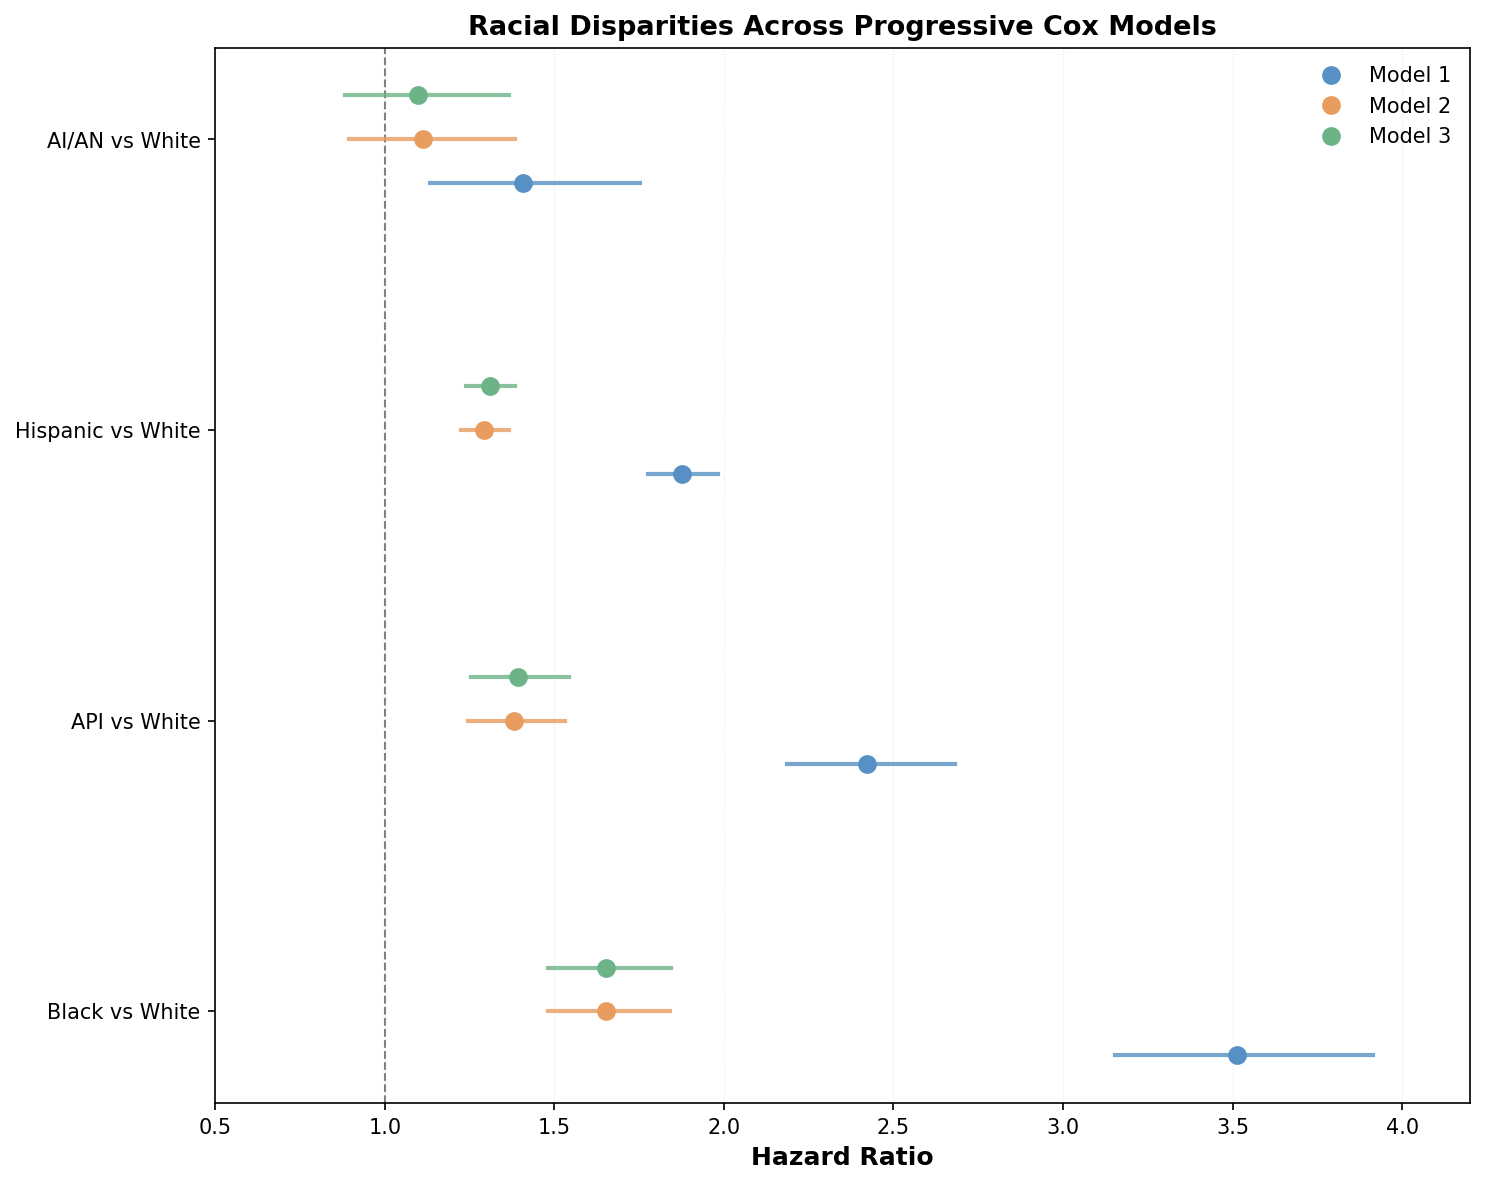

In [99]:
# Combine the models
all_hrs = pd.concat([model1_hrs, model2_hrs, model3_hrs])

# Create forest plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

# Set up positions
race_labels = ['Black vs White', 'API vs White', 'Hispanic vs White', 'AI/AN vs White']
n_races = len(race_labels)
n_models = 3

# Y positions - group by race, offset models within each race
y_base = np.arange(n_races) * 4  # Space between race groups
model_offsets = [-0.6, 0, 0.6]  # Offset for each model within group

colors = ['#5790c4', '#e89c5e', '#6db388']
model_names = ['Model 1', 'Model 2', 'Model 3']

# Plot each race × model combination
for i, race in enumerate(races):
    for j, (model_df, color, offset) in enumerate(zip([model1_hrs, model2_hrs, model3_hrs], 
                                                       colors, model_offsets)):
        row = model_df[model_df['race'] == race].iloc[0]
        y = y_base[i] + offset
        
        # Plot CI as horizontal line
        ax.plot([row['ci_lower'], row['ci_upper']], [y, y], 
                color=color, linewidth=2, alpha=0.8)
        
        # Plot HR as point
        ax.plot(row['hr'], y, 'o', color=color, markersize=8,
                label=model_names[j] if i == 0 else '')

# Reference line at HR=1
ax.axvline(x=1, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# Formatting
ax.set_yticks(y_base)
ax.set_yticklabels(race_labels)
ax.set_xlabel('Hazard Ratio', fontweight='bold', fontsize=12)
ax.set_title('Racial Disparities Across Progressive Cox Models', 
             fontweight='bold', fontsize=13)
ax.set_xlim(0.5, 4.2)
ax.legend(loc='upper right', frameon=False)
ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.savefig('../images/forest_plot_cox_models.png', dpi=150, bbox_inches='tight')
plt.show()